In [1]:
import os
import sys
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Ajouter manuellement le chemin vers le dossier parent du projet
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from simulation.dispo import simulation_disp
from simulation.demand import simulation_demand
from source import recolte_sang


In [2]:
import gurobipy
print(gurobipy.gurobi.version())


(11, 0, 0)


### Simulation de la disponibilité

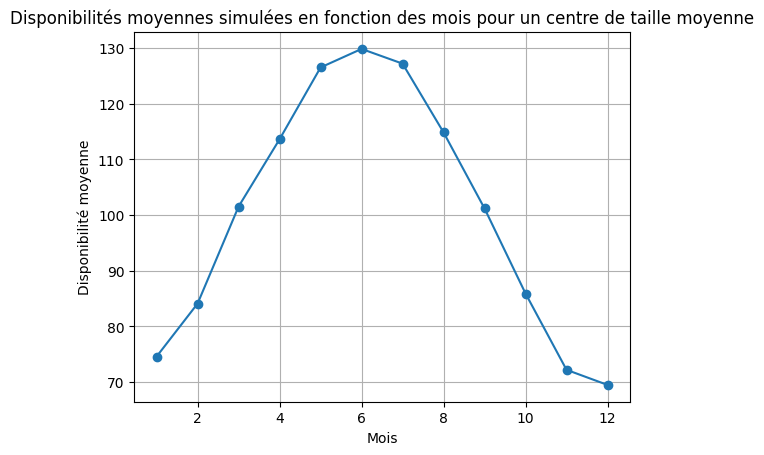

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Nombre de simulations par mois
num_simulations = 500
# Résultats pour chaque mois
r = []

for k in range(1, 13):  # Pour chaque mois
    # Effectuer plusieurs simulations et calculer la moyenne
    disponibilites = [simulation_disp(1, [1], k)[0] for _ in range(num_simulations)]
    r.append(np.mean(disponibilites))  # Moyenne des disponibilités

# Tracer le graphique
plt.plot(range(1, 13), r, marker="o")
plt.xlabel("Mois")
plt.ylabel("Disponibilité moyenne")
plt.title("Disponibilités moyennes simulées en fonction des mois pour un centre de taille moyenne")
plt.grid(True)
plt.show()


### Simulation de la demande de l'hôpital

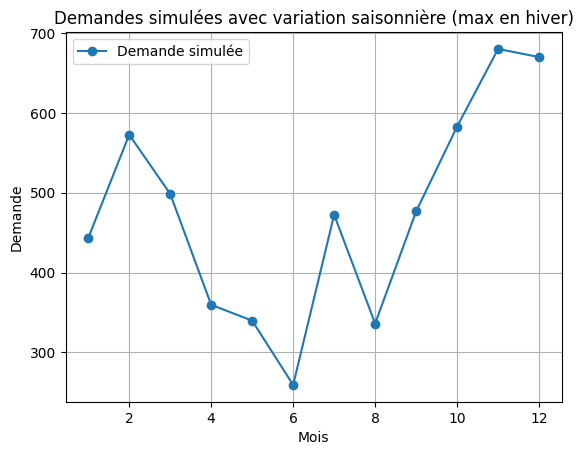

In [23]:
import matplotlib.pyplot as plt

# Paramètres
size = 6  # Taille de l'hôpital (population desservie)
months = range(1, 13)  # Mois de l'année

# Simulations pour chaque mois
demands = [simulation_demand(size, month) for month in months]

# Tracé du graphique
plt.plot(months, demands, marker="o", label="Demande simulée")
plt.xlabel("Mois")
plt.ylabel("Demande")
plt.title("Demandes simulées avec variation saisonnière (max en hiver)")
plt.grid(True)
plt.legend()
plt.show()


## Version déterministe pour une récolte de sang

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-10

Solution optimale trouvée :

Camion 1 utilisé :
  Parcours de 0 à 1 avec distance 3.61 et quantité collectée 0.00
  Parcours de 1 à 4 avec distance 4.47 et quantité collectée 60.00
  Parcours de 4 à 5 avec distance 4.24 et quantité collectée 50.00
  Parcours de 5 à 0 avec distance 3.61 et quantité collectée 20.00
Quantité totale collectée par le camion 1: 130.00

Camion 2 utilisé :
  Parcours de 0 à 3 avec distance 4.12 et quantité collectée 0.00
  Parcours de 3 à 0 avec distance 4.12 et quantité collectée 50.00
Quantité totale collectée par le camion 2: 50.00

Quantité totale collectée par tous les camions : 180.00


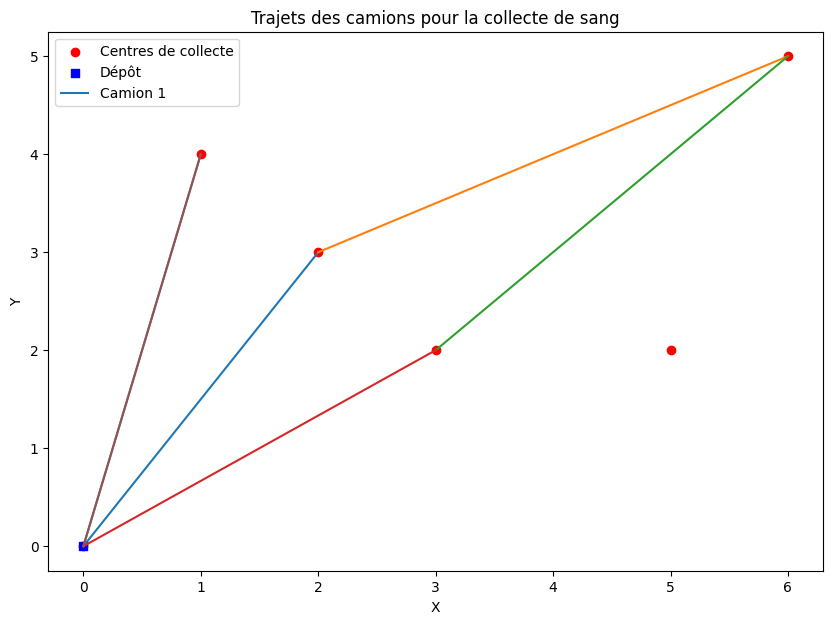

180.0

In [2]:


# Définition des ensembles et paramètres
N = 6  # Nombre de centres de collecte (y compris le dépôt)
K = 2 # Nombre de camions disponibles
Q = 170  # Capacité maximale de chaque camion
S_min = 180  # Seuil minimal de stock à collecter
alpha = 1  # Coût fixe par camion déployé

# Coordonnées fictives pour la visualisation
locations = np.array([
    [0, 0],  # Dépôt
    [2, 3],
    [5, 2],
    [1, 4],
    [6, 5],
    [3, 2]
])

# Demandes des centres
dispo = [0, 60, 40, 50, 50,20]  # Le dépôt n'a pas de demande



recolte_sang(N,K,Q,S_min,alpha,locations,dispo,False)



In [ ]:


# Importer la fonction



r = simulation_disp(5,[1,2,3,4,5],6)

In [ ]:
S = 500  # Stock initial

# Définition des ensembles et paramètres
N = 6  # Nombre de centres de collecte (y compris le dépôt)
K = 7  # Nombre de camions disponibles
Q = 300  # Capacité maximale de chaque camion
alpha = 1  # Coût fixe par camion déployé
stock_file = []  # File d'attente pour gérer la péremption
locations = np.array([
    [0, 0],  # Dépôt
    [2, 3],
    [5, 2],
    [1, 4],
    [6, 5],
    [3, 2]
])

# Simulation sur une année
for m in range(1, 3):  # Parcours des mois
    print(f"\nMois : {m}")
    for week in range(4):  # Parcours des semaines dans un mois
        # Simulation des disponibilités
        dispo = simulation_disp(N - 1, [6] * (N - 1), m)  # Disponibilités par centre
        dispo = np.insert(dispo, 0, 0)  # Ajouter le dépôt
        S_min = 400  # Ajustement du seuil minimal
        S_c = 200 

        print(f"  Semaine {week + 1}")
        print(f"  Disponibilités : {dispo}")

        # Calcul de la récolte de sang
        r ,qt, val_obj= recolte_sang(N, K, Q, S_min, alpha, locations, dispo, False)
        print(f"  Sang récolté : {r}")
        print("Sang collecté dans chaque centre : ",qt)
        print("Valeur obj finale : ",val_obj)

        # Mise à jour du stock
        stock_file.append(r)  # Ajout de la collecte au stock
        print(f"  Stock ajouté à la file : {r}")

        # Consommation quotidienne
        for day in range(7):
            demand_d = int(simulation_demand(1, m))  # Demande quotidienne
            print(f"\nDemande sang jour {day + 1} : {demand_d}, Stock disponible : {sum(stock_file)}")

            if sum(stock_file) >= S_c:  # Si la file de stock n'est pas vide

                # Consommer le stock par ordre FIFO
                remaining_demand = demand_d
                for i in range(len(stock_file)):
                    if stock_file[i] >= remaining_demand:
                        stock_file[i] -= remaining_demand
                        remaining_demand = 0
                        break
                    else:
                        remaining_demand -= stock_file[i]
                        stock_file[i] = 0

                # Retirer les stocks épuisés
                stock_file = [s for s in stock_file if s > 0]
                available_stock = sum(stock_file)
                print(f"    Stock disponible après consommation : {available_stock}")
            else:
                print(" Seuil critique atteint. Déclenchement de la fonction de recours")
                r2 ,qt2, val_obj2= recolte_sang(N, K, Q, S_min, alpha, locations, dispo, False)
                print("Sang récolté 2 : ",r2)
                if r2-demand_d >= 0:
                    stock_file.append(r2-demand_d)


        # Péremption : Supprimer les stocks âgés de plus de 3 semaines
        if len(stock_file) > 3:
            expired = stock_file.pop(0)
            print(f"  Stock périmé retiré : {expired}")

        # Mise à jour du stock total
        S = sum(stock_file)
        print(f"  Nouveau stock après consommation et péremption : {S}")
        print("\n***********\n")
        break
    break
    



Mois : 1
  Semaine 1
  Disponibilités : [  0 673 355 669 324 466]

Solution optimale trouvée :
  Sang récolté : 400.0
Sang collecté dans chaque centre :  {0: 0.0, 1: 300.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 100.0}
Valeur obj finale :  16.42220510185596
  Stock ajouté à la file : 400.0

Demande sang jour 1 : 99, Stock disponible : 400.0
    Stock disponible après consommation : 301.0

Demande sang jour 2 : 80, Stock disponible : 301.0
    Stock disponible après consommation : 221.0

Demande sang jour 3 : 84, Stock disponible : 221.0
    Stock disponible après consommation : 137.0

Demande sang jour 4 : 133, Stock disponible : 137.0
 Seuil critique atteint. Déclenchement de la fonction de recours

Solution optimale trouvée :
Sang récolté 2 :  400.0

Demande sang jour 5 : 107, Stock disponible : 404.0
    Stock disponible après consommation : 297.0

Demande sang jour 6 : 110, Stock disponible : 297.0
    Stock disponible après consommation : 187.0

Demande sang jour 7 : 91, Stock disponible : 1